## Import Jobs

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import sys
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

## Import Data

In [3]:
QUERY = pd.read_csv('/workdir/uvmel_project/data/DF_all_final_matrix.csv')
QUERY.set_index(['Sample ID', 'Legend', 'Patient', 'Cell ID', 'Phenograph_Class'], inplace=True)

In [4]:
QUERY

A1BG  A2M  A4GALT  AAAS  \
Sample ID Legend Patient Cell ID Phenograph_Class                            
0         UM01A  1       1       7                  0.0  3.0     0.0   0.0   
                         2       15                 0.0  1.0     0.0   0.0   
                         3       8                  0.0  2.0     0.0   0.0   
                         4       22                 0.0  0.0     0.0   0.0   
                         6       7                  0.0  0.0     0.0   0.0   
...                                                 ...  ...     ...   ...   
6         UM06   6       19456   19                 0.0  0.0     0.0   0.0   
                         19459   19                 0.0  0.0     0.0   0.0   
                         19460   19                 0.0  0.0     0.0   0.0   
                         19462   19                 0.0  0.0     0.0   0.0   
                         19464   19                 0.0  0.0     0.0   0.0   

                                                   AACS  AADAT  AAED1  AAGAB  \
Sample ID Legend Patient Cell ID Phenograph_Class                              
0         UM01A  1       1       7                  0.0    0.0    0.0    0.0   
                         2       15                 0.0    0.0    0.0    0.0   
                         3       8                  0.0    0.0    0.0    0.0   
                         4       22                 0.0    0.0    0.0    0.0   
                         6       7                  0.0    0.0    0.0    0.0   
...                                                 ...    ...    ...    ...   
6         UM06   6       19456   19                 0.0    0.0    0.0    0.0   
                         19459   19                 0.0    0.0    0.0    0.0   
                         19460   19                 0.0    0.0    0.0    0.0   
                         19462   19                 0.0    0.0    0.0    0.0   
                         19464   19                 0.0    0.0    0.0    0.0   

                                                   AAK1  AAMDC  ...  ZWILCH  \
Sample ID Legend Patient Cell ID Phenograph_Class               ...           
0         UM01A  1       1       7                  1.0    1.0  ...     0.0   
                         2       15                 0.0    0.0  ...     0.0   
                         3       8                  0.0    0.0  ...     0.0   
                         4       22                 0.0    0.0  ...     0.0   
                         6       7                  0.0    0.0  ...     0.0   
...                                                 ...    ...  ...     ...   
6         UM06   6       19456   19                 0.0    0.0  ...     0.0   
                         19459   19                 0.0    0.0  ...     0.0   
                         19460   19                 0.0    0.0  ...     0.0   
                         19462   19                 0.0    0.0  ...     0.0   
                         19464   19                 0.0    0.0  ...     0.0   

                                                   ZWINT  ZXDA  ZXDB  ZXDC  \
Sample ID Legend Patient Cell ID Phenograph_Class                            
0         UM01A  1       1       7                   0.0   0.0   0.0   0.0   
                         2       15                  0.0   0.0   0.0   0.0   
                         3       8                   0.0   0.0   0.0   0.0   
                         4       22                  0.0   0.0   0.0   0.0   
                         6       7                   0.0   0.0   0.0   0.0   
...                                                  ...   ...   ...   ...   
6         UM06   6       19456   19                  0.0   0.0   0.0   0.0   
                         19459   19                  0.0   0.0   0.0   0.0   
                         19460   19                  0.0   0.0   0.0   0.0   
                         19462   19                  0.0   0.0   0.0   0.0   
                         19464 

## Filter Genes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


Count Gene Filter 1: 1361
Count Gene Filter 2: 3993
(17074, 14642)
(17074, 14642)
14642


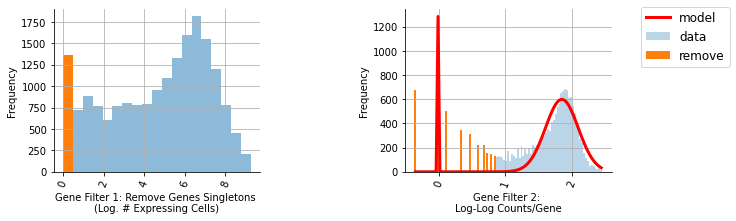

In [7]:
# FIT BINOMIAL DISTRIBUTION AND FILTER BASED ON MEAN/STD OF SECOND
plt.figure(figsize = (10,3))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.7, hspace=0.7) # set the spacing between axes. 

# (4) PLOT LOG NUMBER OF CELLS CONTRIBUTING TO EACH GENE
num_cells_per_gene = np.log(np.sum(QUERY.values > 0,axis=0))
num_cells_per_gene[(np.isinf(num_cells_per_gene)) | (np.isnan(num_cells_per_gene))] = 0
rmv_genes1 = np.where(num_cells_per_gene<=0)[0] # GENES MUST BE DETECTED IN AT LEAST 10 CELLS

ax = plt.subplot(gs1[0])
bins = np.linspace(num_cells_per_gene.min(), num_cells_per_gene.max()*0.95, 20)
plt.hist(num_cells_per_gene, bins, alpha=0.5, label='keep')

if rmv_genes1.any():
    plt.hist(num_cells_per_gene[rmv_genes1], bins, alpha=1, label='remove')
    
#ax.set_axis_bgcolor('white')
plt.xticks(rotation=70)
plt.ylabel('Frequency')
plt.xlabel('Gene Filter 1: Remove Genes Singletons \n(Log. # Expressing Cells)')
plt.grid(True)
sns.despine()

# (5) PLOT LOG COUNTS PER GENE - REMOVE LOW ABUNDANCE GENES
log_counts_per_gene = np.log(np.log(np.sum(QUERY.values,axis=0)))
log_counts_per_gene[(np.isinf(log_counts_per_gene)) | (np.isnan(log_counts_per_gene))] = 0
data = log_counts_per_gene

ax = plt.subplot(gs1[1])
bins = np.linspace(data.min(), data.max()*0.95, 100)
y,x,_=plt.hist(data,bins,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 
expected=(0,.2,3500,1.5,.2,500)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(np.diag(cov))
plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')

mu1 = params[0]
std1 = params[1]
mu2 = params[3]
std2 = params[4]
rmv_genes_neg = np.where(data<mu2-4*std2)[0]
rmv_genes2 = np.sort(list(set(list(rmv_genes_neg))))

if rmv_genes2.any():
    plt.hist(data[rmv_genes2], bins, alpha=1, label='remove')
    
#ax.set_axis_bgcolor('white')
plt.xticks(rotation=70)
plt.ylabel('Frequency')
plt.xlabel('Gene Filter 2: \nLog-Log Counts/Gene')
plt.grid(True)
sns.despine()

# Add (abbreviated) legend bottom left
L = plt.legend(loc='upper right',prop={'size':12},bbox_to_anchor=(1.6, 1.05),fancybox=True) 

# SAVE FIGURE
#figure_label = '_filter_genes'
#fn = FIG_output_stem + FN.replace(".h5", "") + figure_label + '.png'
#plt.savefig(fn, dpi=fig_dpi)
#rint(fn)

# EVALUATE NUMBER OF CELLS/GENES REMOVED
print('Count Gene Filter 1: {}'.format(len(rmv_genes1)))
print('Count Gene Filter 2: {}'.format(len(rmv_genes2)))

# REMOVE SELECTED OUTLIER GENES(HIGHLIGHTED IN GREEN)
CUT_DF = QUERY.copy()
rmv_genes = np.sort(list(set(list(rmv_genes1) + list(rmv_genes2))))
if rmv_genes.any():
    CUT_DF = CUT_DF.drop(CUT_DF.columns[rmv_genes],axis=1)
    print(CUT_DF.shape)
    
# Remove empty genes if they exist
drop_genes = np.where(CUT_DF.sum(axis=0)==0)[0]
CUT_DF = CUT_DF.drop(CUT_DF.columns[drop_genes],axis=1)
print(CUT_DF.shape)

# GENES EXCLUDING LOW ABUNDANCE GENES
goi = list(CUT_DF.columns)
print(len(goi))

In [8]:
QUERY_sub = QUERY.loc[:,goi]

In [9]:
QUERY_sub

A1BG  A2M  A4GALT  AAAS  \
Sample ID Legend Patient Cell ID Phenograph_Class                            
0         UM01A  1       1       7                  0.0  3.0     0.0   0.0   
                         2       15                 0.0  1.0     0.0   0.0   
                         3       8                  0.0  2.0     0.0   0.0   
                         4       22                 0.0  0.0     0.0   0.0   
                         6       7                  0.0  0.0     0.0   0.0   
...                                                 ...  ...     ...   ...   
6         UM06   6       19456   19                 0.0  0.0     0.0   0.0   
                         19459   19                 0.0  0.0     0.0   0.0   
                         19460   19                 0.0  0.0     0.0   0.0   
                         19462   19                 0.0  0.0     0.0   0.0   
                         19464   19                 0.0  0.0     0.0   0.0   

                                                   AACS  AADAT  AAED1  AAGAB  \
Sample ID Legend Patient Cell ID Phenograph_Class                              
0         UM01A  1       1       7                  0.0    0.0    0.0    0.0   
                         2       15                 0.0    0.0    0.0    0.0   
                         3       8                  0.0    0.0    0.0    0.0   
                         4       22                 0.0    0.0    0.0    0.0   
                         6       7                  0.0    0.0    0.0    0.0   
...                                                 ...    ...    ...    ...   
6         UM06   6       19456   19                 0.0    0.0    0.0    0.0   
                         19459   19                 0.0    0.0    0.0    0.0   
                         19460   19                 0.0    0.0    0.0    0.0   
                         19462   19                 0.0    0.0    0.0    0.0   
                         19464   19                 0.0    0.0    0.0    0.0   

                                                   AAK1  AAMDC  ...  ZW10  \
Sample ID Legend Patient Cell ID Phenograph_Class               ...         
0         UM01A  1       1       7                  1.0    1.0  ...   0.0   
                         2       15                 0.0    0.0  ...   0.0   
                         3       8                  0.0    0.0  ...   0.0   
                         4       22                 0.0    0.0  ...   0.0   
                         6       7                  0.0    0.0  ...   0.0   
...                                                 ...    ...  ...   ...   
6         UM06   6       19456   19                 0.0    0.0  ...   0.0   
                         19459   19                 0.0    0.0  ...   0.0   
                         19460   19                 0.0    0.0  ...   0.0   
                         19462   19                 0.0    0.0  ...   0.0   
                         19464   19                 0.0    0.0  ...   0.0   

                                                   ZWILCH  ZWINT  ZXDA  ZXDB  \
Sample ID Legend Patient Cell ID Phenograph_Class                              
0         UM01A  1       1       7                    0.0    0.0   0.0   0.0   
                         2       15                   0.0    0.0   0.0   0.0   
                         3       8                    0.0    0.0   0.0   0.0   
                         4       22                   0.0    0.0   0.0   0.0   
                         6       7                    0.0    0.0   0.0   0.0   
...                                                   ...    ...   ...   ...   
6         UM06   6       19456   19                   0.0    0.0   0.0   0.0   
                         19459   19                   0.0    0.0   0.0   0.0   
                         19460   19                   0.0    0.0   0.0   0.0   
                         19462   19                   0.0    0.0   0.0   0.0   
                         19464   